# Import Libraries

In [49]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier


from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import Pipeline as imbPipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

# Set the decimal format
pd.options.display.float_format = "{:.2f}".format

# laod dataset

In [50]:
import os
df = pd.read_csv(os.path.join('data','diabetes_prediction_dataset.csv'))

In [51]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.00,0,1,never,25.19,6.60,140,0
1,Female,54.00,0,0,No Info,27.32,6.60,80,0
2,Male,28.00,0,0,never,27.32,5.70,158,0
3,Female,36.00,0,0,current,23.45,5.00,155,0
4,Male,76.00,1,1,current,20.14,4.80,155,0


In [52]:
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

Dataset Shape: (100000, 9)

Missing Values:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Data Types:
 gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [53]:
print("The precentage of duplicated data is {:.2f}%".format(df.duplicated().sum()/df.shape[0]*100))

The precentage of duplicated data is 3.85%


In [54]:
df.drop_duplicates(inplace=True)

In [55]:
df.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00,96146.00
mean,41.79,0.08,0.04,27.32,5.53,138.22,0.09
std,22.46,0.27,0.20,6.77,1.07,40.91,0.28
min,0.08,0.00,0.00,10.01,3.50,80.00,0.00
25%,24.00,0.00,0.00,23.40,4.80,100.00,0.00
50%,43.00,0.00,0.00,27.32,5.80,140.00,0.00
75%,59.00,0.00,0.00,29.86,6.20,159.00,0.00
max,80.00,1.00,1.00,95.69,9.00,300.00,1.00


In [56]:
for column in df.columns:
    num_distinct_values = len(df[column].unique())
    print(f"{column}: {num_distinct_values} distinct values")

gender: 3 distinct values
age: 102 distinct values
hypertension: 2 distinct values
heart_disease: 2 distinct values
smoking_history: 6 distinct values
bmi: 4247 distinct values
HbA1c_level: 18 distinct values
blood_glucose_level: 18 distinct values
diabetes: 2 distinct values


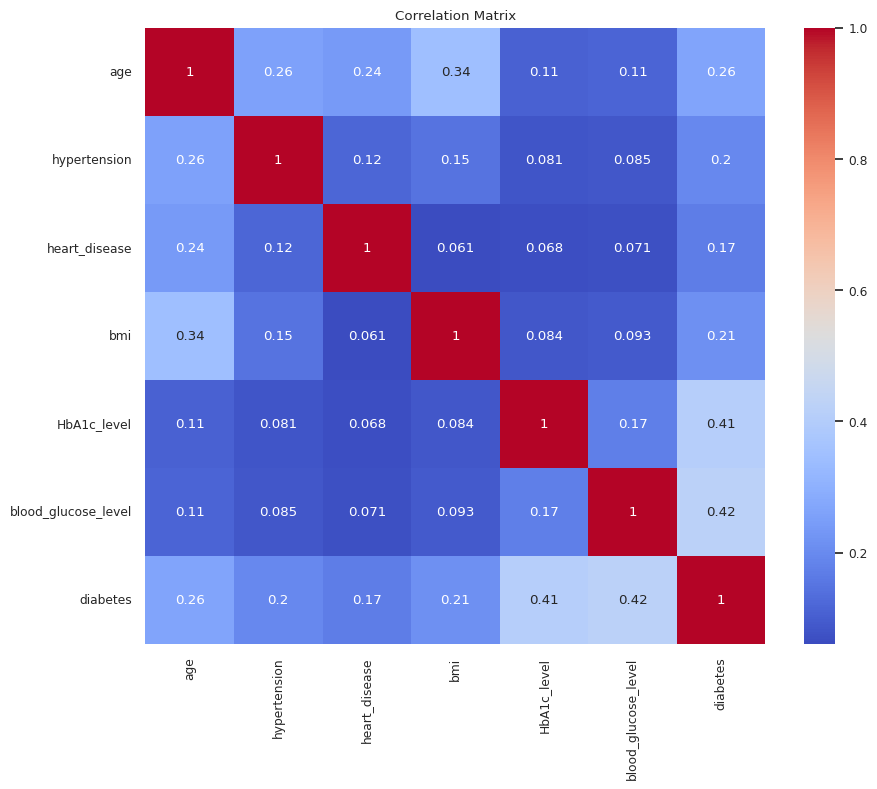

In [57]:
# Correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

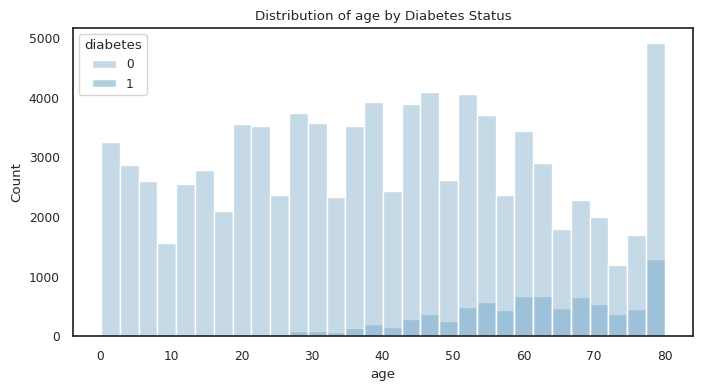

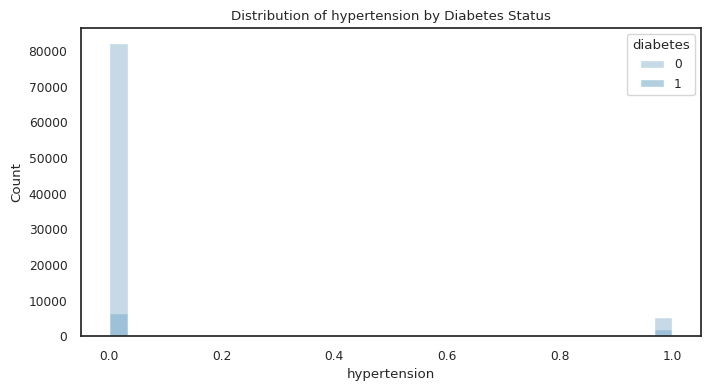

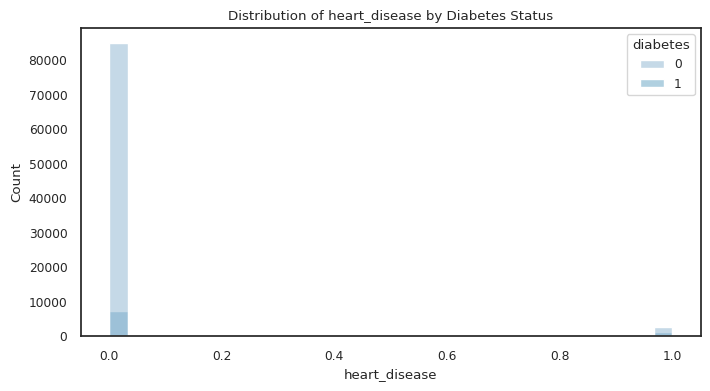

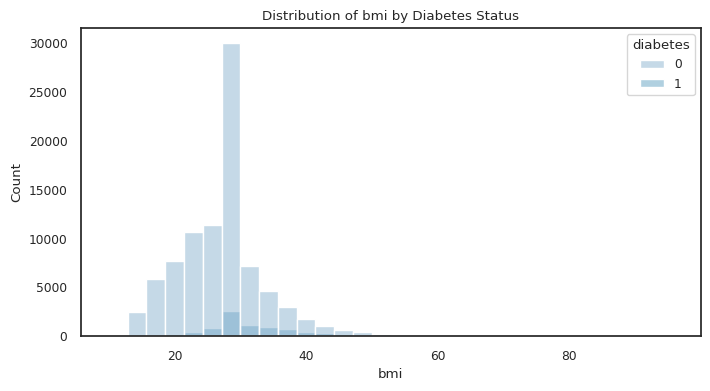

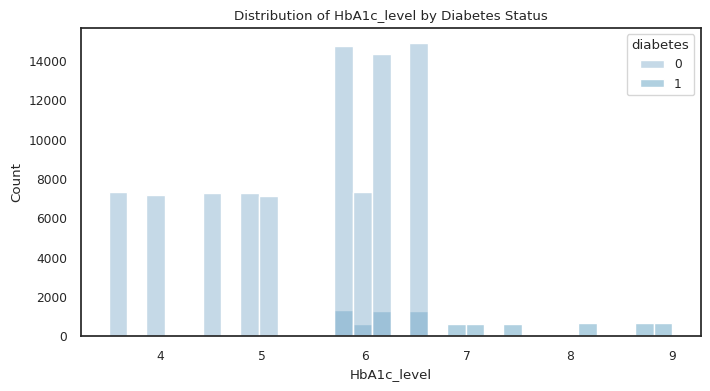

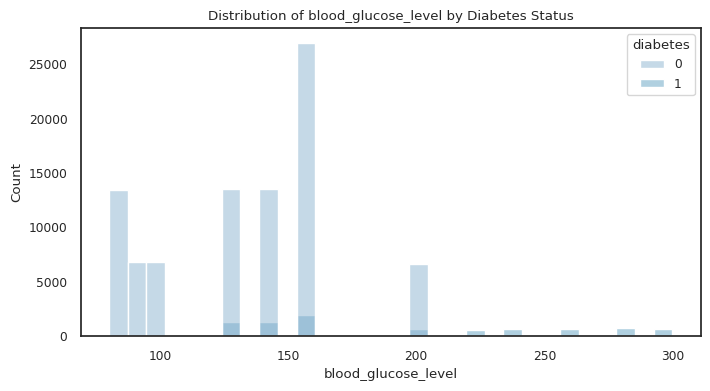

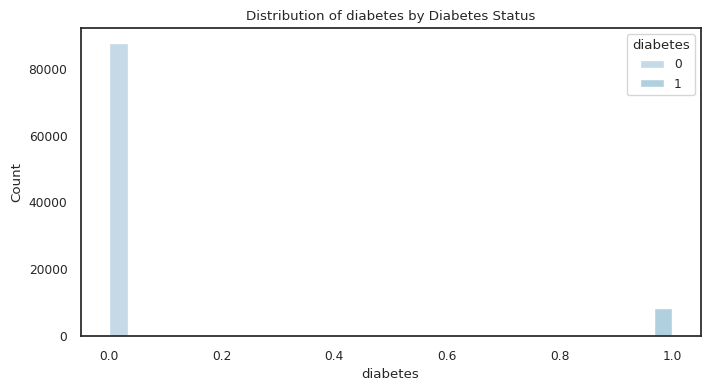

In [58]:
numerical_cols = df.select_dtypes(include=[np.number]).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='diabetes', bins=30)
    plt.title(f'Distribution of {col} by Diabetes Status')
    plt.show()

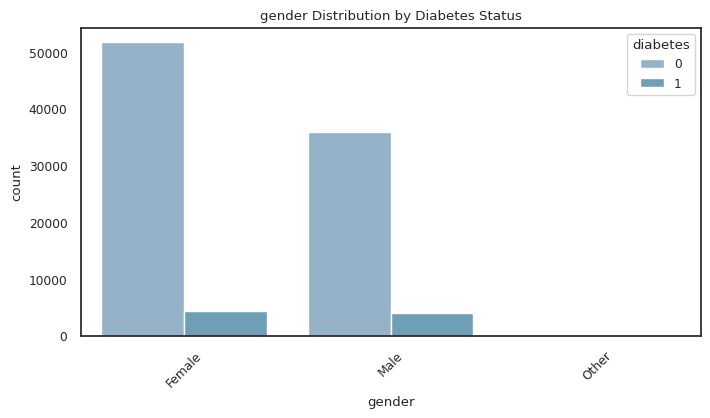

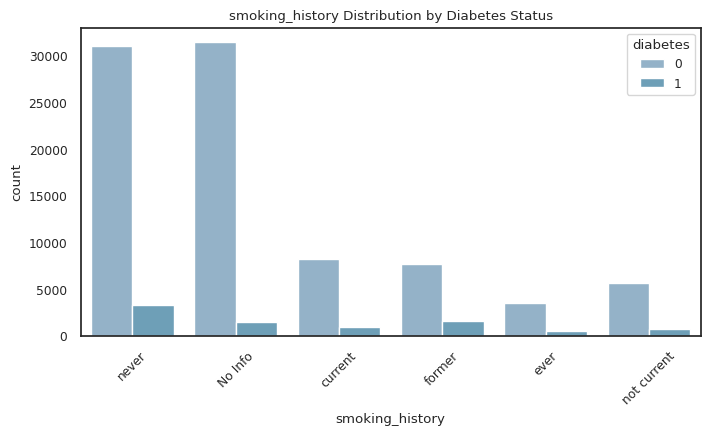

In [59]:
# Categorical features analysis
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='diabetes')
    plt.title(f'{col} Distribution by Diabetes Status')
    plt.xticks(rotation=45)
    plt.show()

In [60]:
# remove other in gender as it not add any value
df = df[df['gender'] != 'Other']

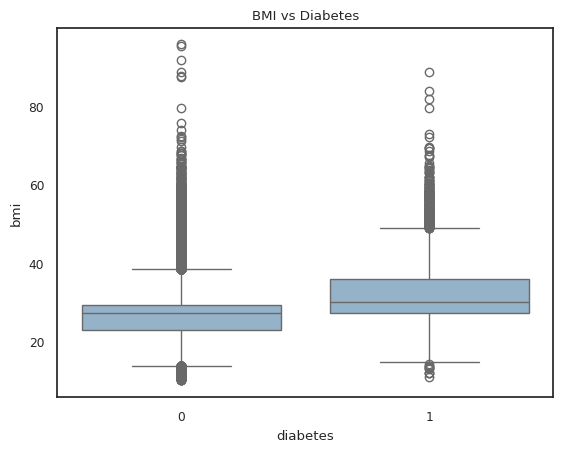

In [61]:
# Boxplot BMI vs Diabetes classification
sns.boxplot(x='diabetes', y='bmi', data=df)
plt.title('BMI vs Diabetes')
plt.show()

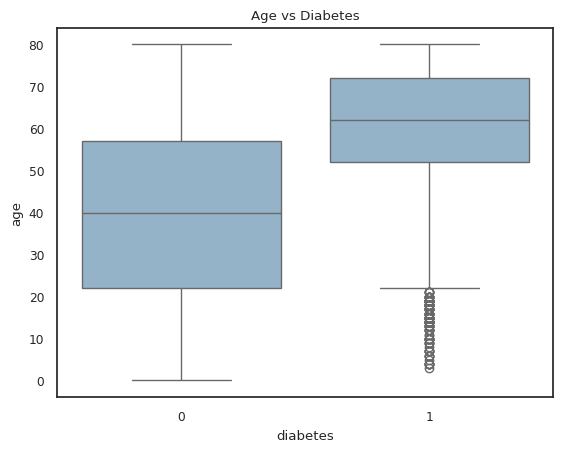

In [62]:
# Boxplot Age vs Diabetes classification
sns.boxplot(x='diabetes', y='age', data=df)
plt.title('Age vs Diabetes')
plt.show()

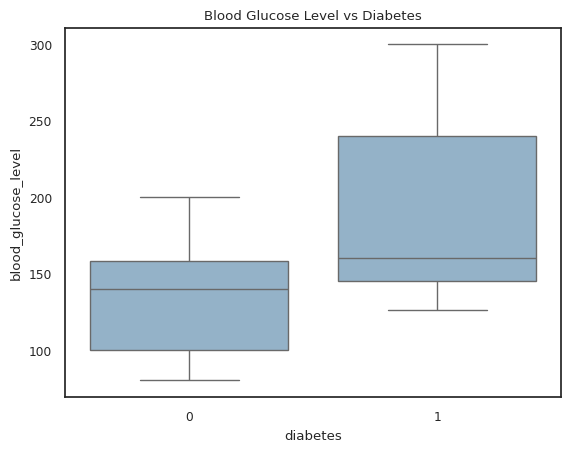

In [63]:
# Boxplot blood glucose level vs Diabetes classification
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df)
plt.title('Blood Glucose Level vs Diabetes')
plt.show()

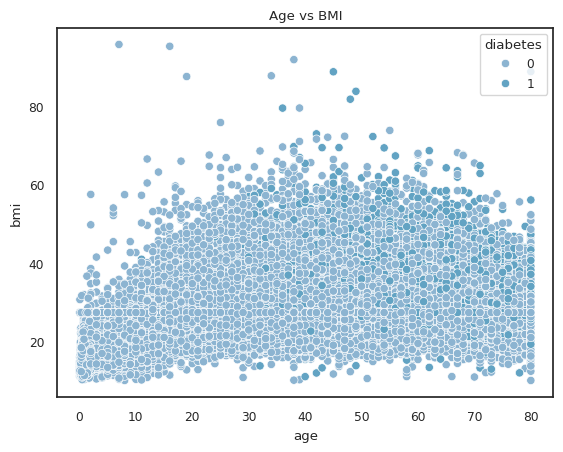

In [64]:
# Scatterplot Age vs BMI colored by Diabetes classification
sns.scatterplot(x='age', y='bmi', hue='diabetes', data=df)
plt.title('Age vs BMI')
plt.show()

In [65]:
data = df.copy()

# Encoding

In [66]:
def perform_one_hot_encoding(df, column_name):
    # Perform one-hot encoding on the specified column
    dummies = pd.get_dummies(df[column_name], prefix=column_name)

    # Drop the original column and append the new dummy columns to the dataframe
    df = pd.concat([df.drop(column_name, axis=1), dummies], axis=1)

    return df

# Perform one-hot encoding on the gender variable
data = perform_one_hot_encoding(data, 'gender')

# Perform one-hot encoding on the smoking history variable
data = perform_one_hot_encoding(data, 'smoking_history')

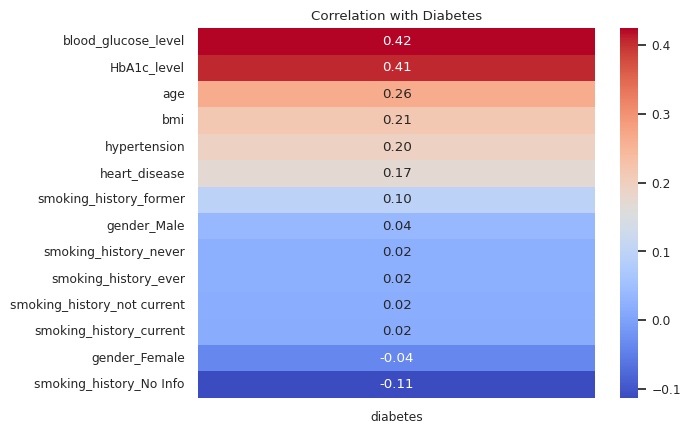

In [67]:
# Create a heatmap of the correlations with the target column
corr = data.corr()
target_corr = corr['diabetes'].drop('diabetes')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.title('Correlation with Diabetes')
plt.show()

diabetes
0   91.20
1    8.80
Name: proportion, dtype: float64


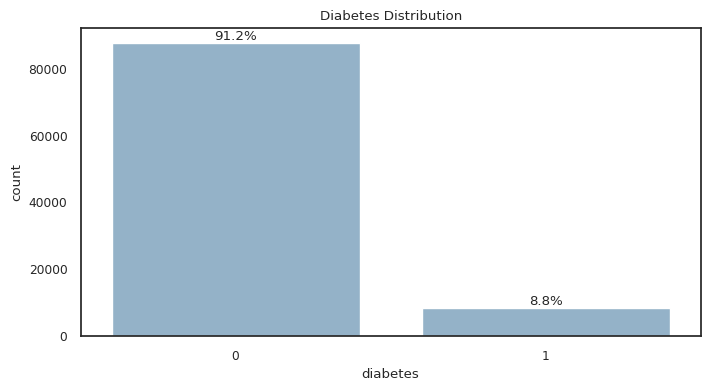

In [68]:
# diabetes distrubtions
diabetes_dist = df['diabetes'].value_counts(normalize=True).round(3) * 100
print(diabetes_dist)
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='diabetes')
plt.title('Diabetes Distribution')

total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.gca().annotate(percentage,
                      (p.get_x() + p.get_width() / 2., p.get_height()),
                      ha='center', va='bottom')
plt.show()

In [69]:
# Define resampling
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)

In [70]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender'])
    ])

# Split data into features and target variable
X = df.drop('diabetes', axis=1)
y = df['diabetes']

In [71]:
# Create a pipeline that preprocesses the data, resamples data, and then trains a classifier
def imbPipeline_(classifier):
    return imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [74]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Define the models to be used
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "k-Nearest Neighbors": KNeighborsClassifier(),
}


In [78]:
# Train and evaluate models
results = {}
for model_name, classifier in models.items():
    # Create pipeline
    clf_pipeline = imbPipeline_(classifier)

    # Fit the pipeline
    clf_pipeline.fit(X_train, y_train)

    # Predictions
    y_pred = clf_pipeline.predict(X_test)
    y_prob = clf_pipeline.predict_proba(X_test)[:, 1] if hasattr(clf_pipeline, "predict_proba") else None

    # Evaluation metrics
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None,
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

In [79]:
# Display results for each model
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    if metrics['ROC-AUC'] is not None:
        print(f"ROC-AUC: {metrics['ROC-AUC']:.2f}")
    else:
        print("ROC-AUC: N/A")
    print("Classification Report:")
    print(metrics["Classification Report"])
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])
    print("-" * 50)

Model: Logistic Regression
Accuracy: 0.94
ROC-AUC: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96     17525
           1       0.60      0.81      0.69      1701

    accuracy                           0.94     19226
   macro avg       0.79      0.88      0.83     19226
weighted avg       0.95      0.94      0.94     19226

Confusion Matrix:
[[16603   922]
 [  323  1378]]
--------------------------------------------------
Model: Support Vector Machine
Accuracy: 0.93
ROC-AUC: 0.97
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96     17525
           1       0.59      0.82      0.69      1701

    accuracy                           0.93     19226
   macro avg       0.79      0.88      0.83     19226
weighted avg       0.95      0.93      0.94     19226

Confusion Matrix:
[[16560   965]
 [  306  1395]]
------------------------------------

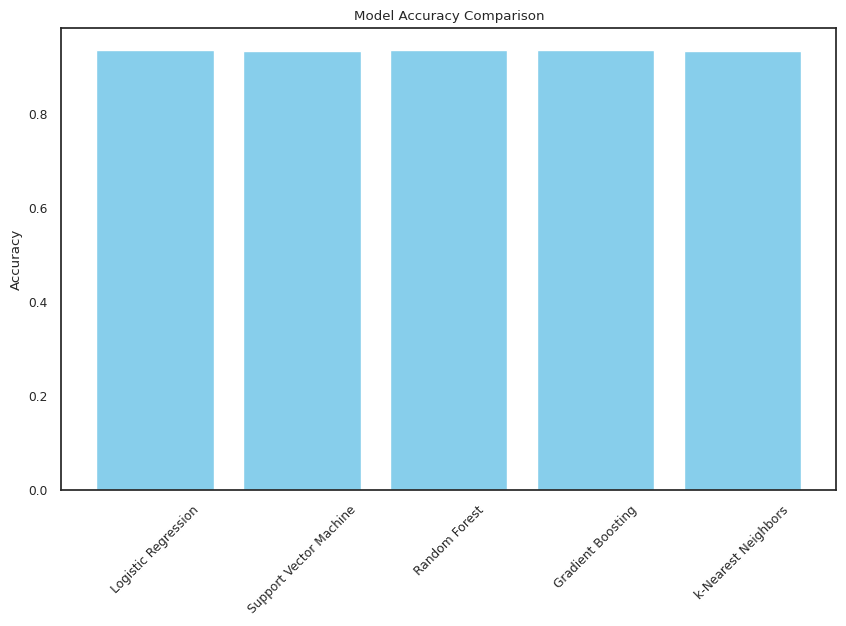

In [80]:
# Visualize accuracy comparison
accuracy_scores = {model: metrics["Accuracy"] for model, metrics in results.items()}
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

# Model Building and Hyperparameter Tuning


In [85]:
# Define the hyperparameters and the values we want to test
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 250, 300],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [1, 2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4, 6, 8]
}

In [ ]:
# fine tuning  Random Forest
clf_pipeline = imbPipeline_(RandomForestClassifier())
# Create Grid Search object
grid_search = GridSearchCV(clf_pipeline, param_grid, cv=5)

# Train the model
grid_search.fit(X_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Model Accuracy:  0.9506917715593467
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     17525
           1       0.69      0.79      0.74      1701

    accuracy                           0.95     19226
   macro avg       0.84      0.88      0.86     19226
weighted avg       0.95      0.95      0.95     19226



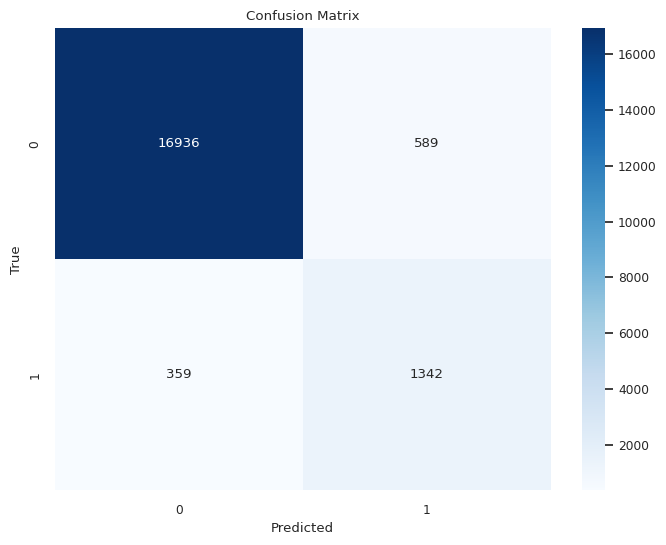

In [84]:
# Predict on the test set using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()